# CNN Baseline model 

Largely inspired by Kaggle MNIST approach:

https://www.kaggle.com/code/elcaiseri/mnist-simple-cnn-keras-accuracy-0-99-top-1/notebook

The architecture is only slightly adapted to account for bigger images.
Many lines of code are directly copeid form the above mentioned example.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import keras
from keras.models import Sequential
from keras.layers import Conv2D, Lambda, MaxPooling2D, Rescaling # convolution layers
from keras.layers import Dense, Dropout, Flatten # core layers
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization

from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder

import json 

from utils import plot_cm


In [2]:
input_shape = (58, 58)

adaptive_based_on_val = True  # if False, then uses ada_delta with decay, else uses stopping and decay based on val_acc

In [3]:
if adaptive_based_on_val:
    train_ds = tf.keras.utils.image_dataset_from_directory(
        "images/train",
        validation_split=0.1,
        subset="training",
        seed=20,
        image_size=input_shape,
        label_mode="categorical",
        shuffle=True,
        color_mode="grayscale",
    )

    val_ds = tf.keras.utils.image_dataset_from_directory(
        "images/train",
        validation_split=0.1,
        subset="validation",
        seed=20,
        image_size=input_shape,
        batch_size=64,
        label_mode="categorical",
        shuffle=False,
        color_mode="grayscale",
    )
else:
    train_ds = tf.keras.utils.image_dataset_from_directory(
        "images/train",
        seed=42,
        image_size=input_shape,
        label_mode="categorical",
        shuffle=True,
        batch_size=1000,
        color_mode="grayscale",
    )


Found 7462 files belonging to 9 classes.
Using 6716 files for training.
Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2022-09-15 20:49:10.784906: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-15 20:49:10.785085: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 7462 files belonging to 9 classes.
Using 746 files for validation.


In [4]:
model=Sequential()

model.add(Rescaling(1./127.5, offset=-1, input_shape=(input_shape[0], input_shape[1], 1)))
model.add(Conv2D(filters=64, kernel_size = (6,6), activation="relu", strides=(2, 2)))
model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())    

model.add(Conv2D(filters=256, kernel_size = (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
    
model.add(Flatten())
model.add(Dense(512,activation="relu"))
    
model.add(Dense(9,activation="softmax"))
if adaptive_based_on_val:
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])
else:
    ada_delta_ = keras.optimizers.Adadelta(lr=1, rho=0.95, epsilon=1e-08, decay=0.03)
    model.compile(loss="categorical_crossentropy", optimizer=ada_delta_, metrics=["accuracy"])

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 58, 58, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 27, 27, 64)        2368      
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 12, 12, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 128)       7

In [6]:
if adaptive_based_on_val:
    es = keras.callbacks.EarlyStopping(
            monitor="val_accuracy", # metrics to monitor
            patience=10, # how many epochs before stop
            verbose=1,
            mode="max", # we need the maximum accuracy.
            restore_best_weights=True, # 
            )

    rp = keras.callbacks.ReduceLROnPlateau(
            monitor="val_accuracy",
            factor=0.2,
            patience=3,
            verbose=1,
            mode="max",
            min_lr=0.00001,
            )
    h = model.fit(train_ds, validation_data=val_ds, epochs=200, callbacks=[rp, es])
    # Do 5 epochs with a lower learning rate
    model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=1e-5), metrics=["accuracy"])
    h = model.fit(val_ds, epochs=5)
else:
    h = model.fit(train_ds, epochs=140)

Epoch 1/200


2022-09-15 20:49:11.710358: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-09-15 20:49:11.710524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


210/210 [==============================] - ETA: 0s - loss: 2.1857 - accuracy: 0.1939

2022-09-15 20:49:15.470084: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


210/210 [==============================] - 4s 18ms/step - loss: 2.1857 - accuracy: 0.1939 - val_loss: 2.7413 - val_accuracy: 0.3499 - lr: 0.0010
Epoch 2/200
210/210 [==============================] - 4s 17ms/step - loss: 2.0171 - accuracy: 0.2297 - val_loss: 2.7206 - val_accuracy: 0.0080 - lr: 0.0010
Epoch 3/200
210/210 [==============================] - 3s 16ms/step - loss: 1.9147 - accuracy: 0.2644 - val_loss: 1.9547 - val_accuracy: 0.2466 - lr: 0.0010
Epoch 4/200
210/210 [==============================] - 3s 16ms/step - loss: 1.8018 - accuracy: 0.2936 - val_loss: 1.5812 - val_accuracy: 0.5174 - lr: 0.0010
Epoch 5/200
210/210 [==============================] - 3s 16ms/step - loss: 1.7392 - accuracy: 0.3149 - val_loss: 1.8010 - val_accuracy: 0.3753 - lr: 0.0010
Epoch 6/200
210/210 [==============================] - 3s 16ms/step - loss: 1.6714 - accuracy: 0.3374 - val_loss: 1.5746 - val_accuracy: 0.5094 - lr: 0.0010
Epoch 7/200
207/210 [============================>.] - ETA: 0s - loss:

2022-09-15 20:58:11.274769: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 1s 27ms/step - loss: 4.4321 - accuracy: 0.2131
Epoch 2/5
12/12 [==============================] - 0s 18ms/step - loss: 4.1286 - accuracy: 0.2292
Epoch 3/5
12/12 [==============================] - 0s 18ms/step - loss: 3.8862 - accuracy: 0.2373
Epoch 4/5
12/12 [==============================] - 0s 18ms/step - loss: 3.6739 - accuracy: 0.2601
Epoch 5/5
12/12 [==============================] - 0s 18ms/step - loss: 3.4834 - accuracy: 0.2842


In [42]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    "images/test",
    validation_split=None,
    seed=42,
    image_size=input_shape,
    batch_size=2000,
    label_mode="categorical",
    shuffle=False,
    color_mode="grayscale",
)
for image_batch, labels_batch in test_ds:
  y_test_true = np.array(labels_batch)

Found 1865 files belonging to 9 classes.


In [43]:
y_pred = model.predict(test_ds) # Predict class probabilities as 2 => [0.1, 0, 0.9, 0, 0, 0, 0, 0, 0, 0]
Y_pred = np.argmax(y_pred, 1) # Decode Predicted labels
Y_test_true = np.argmax(y_test_true, 1) # Decode Predicted labels

1/1 [==============================] - 0s 81ms/step


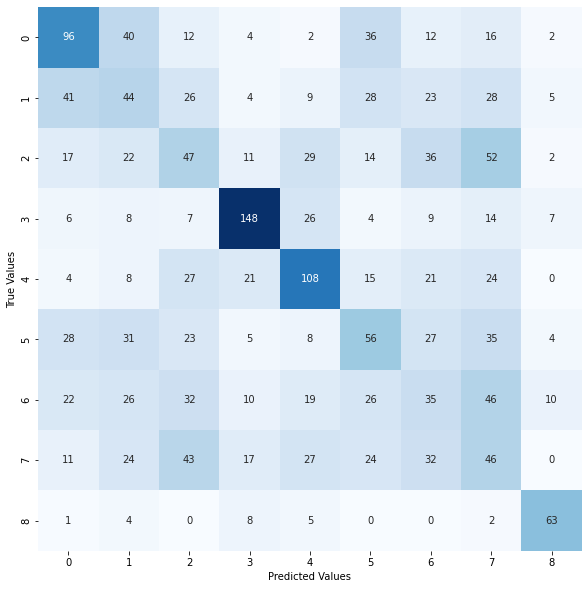

In [50]:
fig = plt.figure(figsize=(10, 10)) # Set Figure

mat = confusion_matrix(Y_test_true, Y_pred) # Confusion matrix

# Plot Confusion matrix
sns.heatmap(mat, square=True, annot=True, cbar=False, cmap=plt.cm.Blues, fmt='.0f')
plt.xlabel('Predicted Values')
plt.ylabel('True Values');
plt.show();

In [10]:
f1_score(Y_test_true, Y_pred, average='macro')

0.36742662050402825

In [11]:
with open('data/le_name_mapping.json', 'r') as f:
    mapping = json.load(f)
    le = LabelEncoder()
mapping['classes'] = [mapping[str(int(i))] for i in range(9)]
le.classes_ = np.array(mapping['classes'])

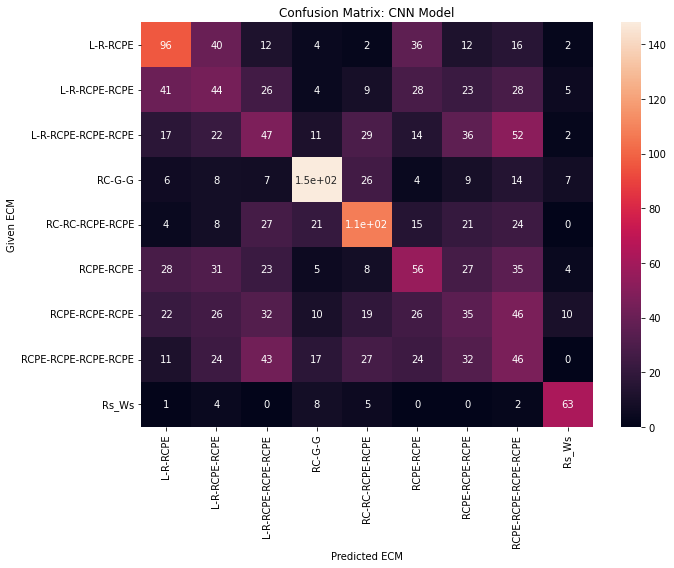

Test Accuracy: 0.36742662050402825


In [38]:
plot_cm(Y_test_true, Y_pred, le, save=0, title='Confusion Matrix: CNN Model', figname='cnn_cm', save_path='figures/CNN/')

proportion_correct = f1_score(Y_test_true, Y_pred, average='macro')
print('Test Accuracy: {}'.format(proportion_correct))

In [46]:
Y_test_true[:20]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [47]:
Y_pred[:20]

array([1, 2, 0, 0, 3, 0, 7, 0, 0, 0, 0, 0, 7, 0, 0, 2, 0, 0, 0, 1])